In [1]:
import gym
import myosuite
from stable_baselines3 import PPO
from gym.envs.registration import register
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ENV Registration
ENV_NAME = 'Reach-v0'
MODEL_PATH = 'C:/Personal/Second year/Sem 2/Project Course/trial_elbow/myoelbow_2dof6muscles.xml'
register(id=ENV_NAME,
        entry_point='myosuite.envs.myo.myobase.reach_v0:ReachEnvV0',
        max_episode_steps=200,
        kwargs={
            'model_path': MODEL_PATH,
            'target_reach_range': {'wrist': ((-0.2, -0.15, 0.9), (-0.2, -0.15, 0.9)), },
            'normalize_act': True,
        }
)

MyoSuite:> Registering Myo Envs


c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py", line 594, in load_plugin_envs
    fn()
  File "c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\shimmy\registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\shimmy\registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\shimmy\dm_control_compatibility.py", line 20, in <module>
    from gymnasium.envs.mujoco.mujoco_rendering import MujocoRenderer
  File "c:\Users\hardi\A

In [2]:
env = gym.make('Reach-v0', seed=1)
obs = env.reset()

# Training Part
eval_env = gym.make('Reach-v0', seed=1)
eval_env.reset()

# Set up the callback
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [3]:
env.sim.data.site('wrist')

<_MjDataSiteViews
  id: 39
  name: 'wrist'
  xmat: array([ 7.9633e-04, -5.5511e-17, -1.0000e+00, -1.0000e+00,  7.9633e-04,
       -7.9633e-04,  7.9633e-04,  1.0000e+00,  6.3414e-07])
  xpos: array([-0.2227,  0.0838,  0.8416])
>

In [4]:
observations_x=[-0.2]
observations_y=[-0.15]
observations_z=[0.9]

In [5]:
from time import sleep
model = PPO("MlpPolicy", env, verbose=1, device=device)
model.learn(total_timesteps=50000, callback=eval_callback)
model.save("myoelbow_model")

# Testing Trained RL Model
model.load("myoelbow_model")
done = False
while not done:
    act, _ = model.predict(obs)
    sleep(0.1)
    obs, reward, done, info = env.step(act)
    observations_x.append(env.sim.data.site('wrist').xpos[0])
    observations_y.append(env.sim.data.site('wrist').xpos[1])
    observations_z.append(env.sim.data.site('wrist').xpos[2])
    print(done, act, obs)
    env.mj_render()



Using cuda:0 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\hardi\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=-31.51 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | -31.5    |
| time/              |          |
|    total_timesteps | 500      |
---------------------------------
New best mean reward!
Eval num_timesteps=1000, episode_reward=-31.51 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | -31.5    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
Eval num_timesteps=1500, episode_reward=-31.51 +/- 0.00
Episode length: 200.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 200      |
|    mean_reward     | -31.5    |
| time/              |          |
|    total_timesteps | 1500     |
---------------------------------
E

Text(0.5, 1.0, 'X coordinate')

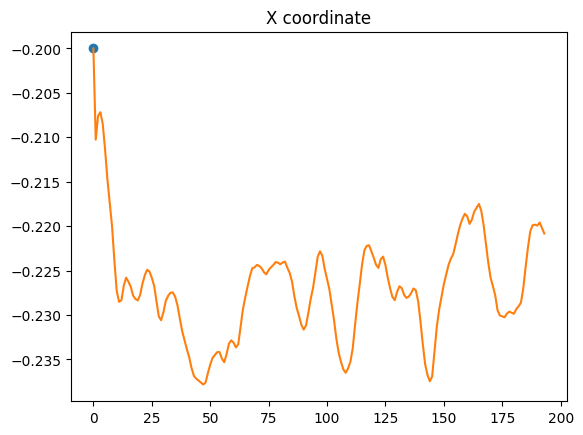

In [6]:
plt.plot(observations_x[0], 'o')
plt.plot(observations_x)
plt.title('X coordinate')

Text(0.5, 1.0, 'Y coordinate')

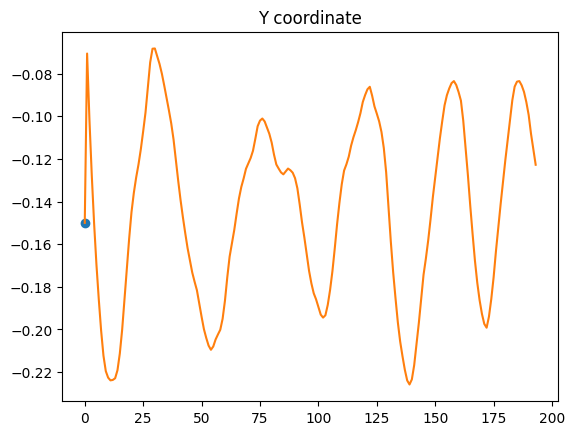

In [7]:
plt.plot(observations_y[0], 'o')
plt.plot(observations_y)
plt.title('Y coordinate')

Text(0.5, 1.0, 'Z coordinate')

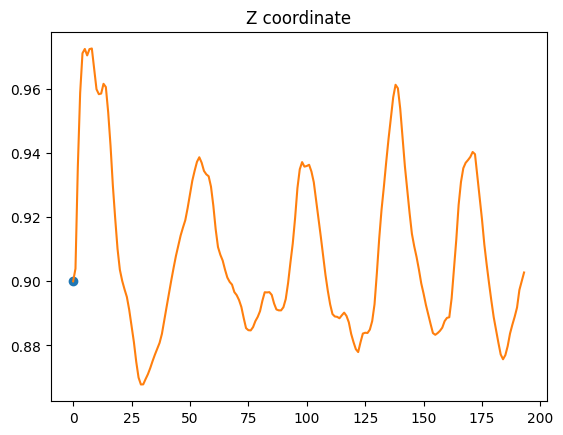

In [8]:
plt.plot(observations_z[0], 'o')
plt.plot(observations_z)
plt.title('Z coordinate')

In [9]:
# plt.plot(observations_qpos, label='pos')
# plt.plot(observations_qvel, label='vel')
# # plt.plot(rewards, label='reward')
# plt.legend()
# plt.show()
# print(info)
# print()
# print(obs)
# print()
# print(act)

[qpos, qvel, (tip_pos, tip_pos, tip_pos), (reach_err, reach_err, reach_err), next 6 act]